# **Text Mining Project** 

|     |     Student Name      |    Student ID   |
|---  |         ---           |       ---       |
|  1  |      Mariana Cabral   |     20230532    |
|  2  |      Sofia Pereira    |     20230568	|
|  3  |      Susana Pires     |     20230540    |

Docs for orgaization: https://docs.google.com/document/d/1cU9rkjof2L1qmxQwBYIpzOMezUiTN0xATmCpiLne1_c/edit?usp=sharing

Link for report: https://liveeduisegiunl-my.sharepoint.com/:w:/g/personal/20230568_novaims_unl_pt/Ee5Xaa2zAJtOj_6C7T8apkgB3_gYWxfbe4SQxlCq9Ld0PA?e=YFEFAF

### Goal: 
**Implement an NLP Classification model able to predict, for each property, if it was unlisted (1) in the next quarter or is still listed (0)**


## **1. Import Libraries &  Documents:**

#### Libraries:

In [1]:
# %pip install bs4
# %pip install nltk
# %pip install openpyxl
# %pip install langdetect

In [4]:
# %pip install fasttext-langdetect
# thrown some errors, let's check if it works
# ERROR: Could not build wheels for fasttext, which is required to install pyproject.toml-based projects

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Preprocessing and Feature Extraction
from bs4 import BeautifulSoup #remove html tags

# Language detection
from langdetect import detect, DetectorFactory
# from ftlangdetect import detect as ft_detect

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\susan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\susan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\susan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Documents:

The **Corpora** is composed by the following documents:

•  _`airbnb_df_train `_(train.xlsx) (6,248 lines): Contains the Airbnb and host descriptions
(“description” and “host_about” columns), as well as the information regarding the
property listing status (“unlisted” column). A property is considered unlisted (1) if
it got removed from the quarterly Airbnb list and it is considered listed (0) if it
remains on that same list.

• _`airbnb_df_train_reviews`_ (train_reviews.xlsx) (361,281 lines): This file has all the guests’
comments made to each Airbnb property. Note that there can be more than one
comment per property, not all properties have comments, and comments can
appear in many languages.

• _`airbnb_df_test`_ (test.xlsx) (695 lines): The structure of this dataset is the same as the train set, except that it does not contain the “unlisted” column.

• _`airbnb_df_test_reviews `_ (test_reviews.xlsx) (41,866 lines): same srtucter as the train reviews set, but the comments correspond to the properties
present on the test set.

**Important notes** about the relation between  _`airbnb_df_train `_ &  _`airbnb_df_train_reviews`_:
- There can be more than one comment per listing;
- Not all properties have comments;
- Comments can appear in many languages;

In [8]:
airbnb_df_train = pd.read_excel('Project Corpora/train.xlsx')
airbnb_df_train_reviews = pd.read_excel('Project Corpora/train_reviews.xlsx')
airbnb_df_test= pd.read_excel('Project Corpora/test.xlsx')
airbnb_df_test_reviews = pd.read_excel('Project Corpora/test_reviews.xlsx')

In [9]:
airbnb_df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [10]:
airbnb_df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


## **TO DO:**
- Create Copy of Data and work with that;
- Language detection -> langdetect (https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430) for all text varibles;
- Decide if we think host_about is important (since it repeats so many times as each host can have more than 1 property);
- Check how many properties have comments;
- Check small text (does it have any meaning?);
- Treat Emojis;
- If we have languages we can calculate stopwords and all for all of them;
- Test different models for each feature engineering method (and with and without undersampling/oversapling).

----

## **2. Data Exploration**

###  **2.1 Documents General Analysis:**

We start by checking if the indexes in *airbnb_df_train* are unique:

In [11]:
airbnb_df_train['index'].nunique()

6248

Since 6248 is equal to the number of total lines, there are no duplicated indexes and so the column "index"  can be turned into the index of the dataframe:

In [12]:
airbnb_df_train.set_index('index', inplace = True)
airbnb_df_train.head()

,description,host_about,unlisted
index,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


Let's do the same verification for *airbnb_df_test*:

In [13]:
airbnb_df_test['index'].nunique()

695

We came to the same conclusion, so the same thing is done for the test set:

In [14]:
airbnb_df_test.set_index('index', inplace = True)
airbnb_df_test.head()

,description,host_about
index,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
4,Charming Apartment Close to the Bay of Cascais...,:)
5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


We then check for the size of our datasets:

In [15]:
airbnb_df_train.shape, airbnb_df_test.shape

((6248, 3), (695, 2))

We have **6248** records in the train dataset and **695** on the test.

In [16]:
airbnb_df_train_reviews.shape, airbnb_df_test_reviews.shape

((361281, 2), (41866, 2))

We have **361281** reviews in train and **41866** in test.



**Conclusion:**
This shows that the variable *comments* contains a lot more information than other variables. We now need to understand if this information is revelant/coherent for the problem.

In [17]:
airbnb_df_train.duplicated().sum()

192

There are also **192** duplicated entries in the train set.

In [18]:
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(keep = False)]
duplicated_rows.head()

,description,host_about,unlisted
index,,,
17,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
45,"Welcome to this well-appointed, charming and v...",I do not spare any efforts when it comes to tr...,0
58,there are 4 rooms in this apartment. this room...,我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.,0
76,Nesha Guesthouse Lisbon is a surf & beach orie...,I'm an enthusiastic and active person who love...,0
78,"Located in Chiado district, one of the trendie...",Hi! Welcome to Lisbon Five Stars apartments. \...,0


 **NOTE:** 
- We will treat duplicated entries as different properties (as per indication of teachers) - it can be a house with different rooms listed.
- All our text fields have text in different languages (Portuguese, English, French...);

### **2.2 Feature Analysis**

####  **2.2.1 unlisted:** Target variable 

0: remains on list <br>
1: got unlisted

In [19]:
airbnb_df_train['unlisted'].describe()

count    6248.000000
mean        0.273367
std         0.445724
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [20]:
airbnb_df_train['unlisted'].unique()

array([0, 1], dtype=int64)

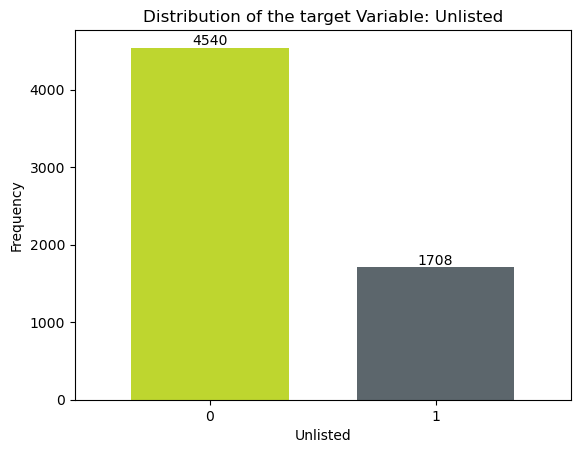

In [21]:
# Plotting
ax = airbnb_df_train['unlisted'].value_counts().plot(kind='bar', color=['#BED62F', '#5C666C'], width=0.7)
plt.grid(False)
plt.title('Distribution of the target Variable: Unlisted')
plt.xlabel('Unlisted')
plt.ylabel('Frequency')

# Rotating x-label values vertically
plt.xticks(rotation='horizontal')

# Annotating total values on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

In [22]:
airbnb_df_train['unlisted'].value_counts(normalize=True)*100

unlisted
0    72.663252
1    27.336748
Name: proportion, dtype: float64

**Conclusions - Target Analysis:**
* No **mising values**  (i.e count = total number of lines)
* No **unexpected values** 
* There is a clear **imbalance**: around 73% of the training instances represent airbnb's that remain listed, while only 27% represent airbnb's that were unlisted.
    - This is an important characteristic of the data, as unbalanced data needs to be adressed so it does not affect the performance of our classification models.

#### **2.2.2 description:**

##### **1) Missing Values & Duplicates**

In [23]:
airbnb_df_train['description'].isna().sum()

0

In [24]:
airbnb_df_train['description'].duplicated().sum()

225

**Conclusions**:

There are **no missing values** for this varible, but we note that there are **duplicated descriptions**.

##### **2) Word Count** 
Turn text into words to better analyse it:
Turning our descriptions into tokens and counting how many tokens exist in each description:

In [25]:
airbnb_df_train['word_count_descr']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_descr']].head() #number of tokens

,description,word_count_descr
index,,
1,"This is a shared mixed room in our hostel, wit...",127
2,"O meu espaço fica perto de Parque Eduardo VII,...",23
3,Trafaria’s House is a cozy and familiar villa ...,170
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
5,Joli appartement en bordure de mer.<br /> 2 m...,101


In [26]:
airbnb_df_train.word_count_descr.describe().round(2)

count    6248.00
mean      132.86
std        48.08
min         3.00
25%        99.00
50%       157.00
75%       167.00
max       210.00
Name: word_count_descr, dtype: float64

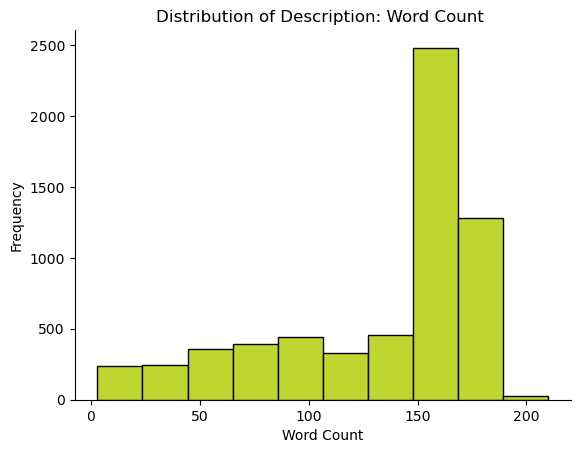

In [27]:
airbnb_df_train['word_count_descr'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of Description: Word Count ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description has 210 words
- The smallest description has only 3 words
- On average, descriptions have around 133 words
- The description file contains text with many different sizes, by is most commonly around [150,170] words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [28]:
all_words_descr = ' '.join(airbnb_df_train['description']).split()

In [29]:
freq_descr = pd.Series(all_words_descr).value_counts() # see frequency of words

Cheking the **most common words**:

In [30]:
freq_descr.sort_values(ascending=False)[0:25]

the             31323
and             27698
a               25540
/><br           17380
to              15328
of              15122
in              13866
with            13649
is              12083
de               6918
apartment        6841
for              6153
you              6140
<br              5328
has              4863
space</b><br     4814
/><b>The         4670
from             4363
e                4288
/>The            4144
The              3426
are              3155
room             3016
located          2944
2                2937
Name: count, dtype: int64

Vizualising using a barplot:

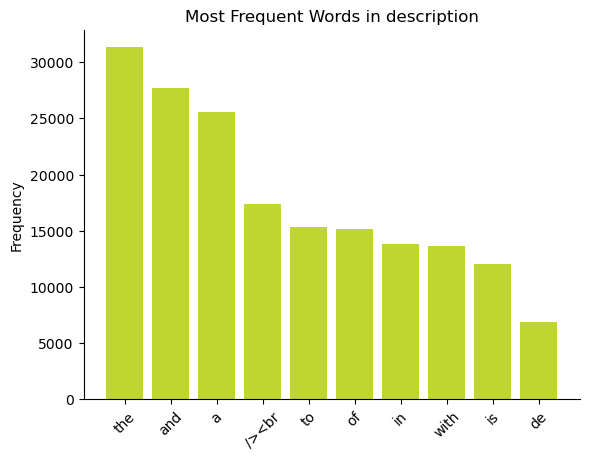

In [31]:
x_labels = freq_descr.index[0:10]
values = freq_descr[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

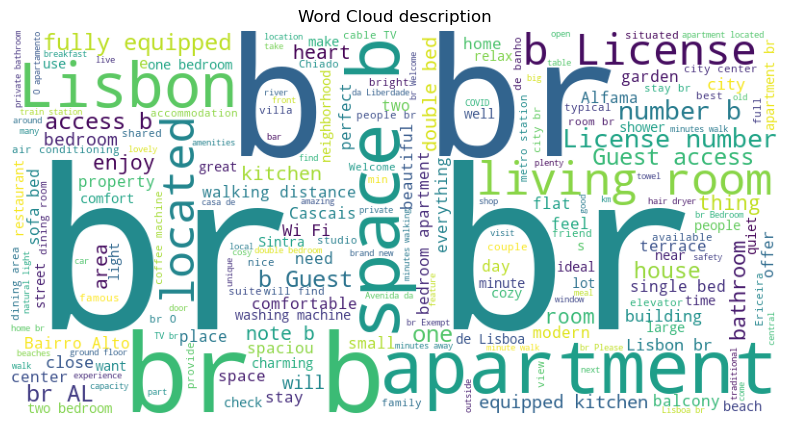

In [32]:
# Joining all the descriptions into a single string
all_reviews_descr = ' '.join(airbnb_df_train['description'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud description')
plt.show()

**Conclusions**:

There are clearly a lot of **uniformative words** that can be considered *stop words*, *tags* or *non-alphanumeric*, such as 'br', 'and' 'the'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.3 host_about:**

##### **1) Missing Values & Duplicates**

In [33]:
airbnb_df_train['host_about'].isna().sum()

0

In [34]:
airbnb_df_train['host_about'].duplicated().sum()

3445

**Conclusions**:

Once again, there are **no missing values** but we have many **duplicated hosts**, which is expected as a host can have more than one listing.

##### **2) Word Count** 
Repeat the process but this time for the variable *host_about*

In [35]:
airbnb_df_train['word_count_host']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host']].head() #number of tokens

,host_about,word_count_host
index,,
1,Alojamento Local Registro: 20835/AL,4
2,"I am friendly host, and I will try to always b...",24
3,"I am a social person liking to communicate, re...",45
4,Hello!_x000D_\nI m Portuguese and i love to me...,31
5,Nous sommes une famille avec deux enfants de 1...,37


In [36]:
airbnb_df_train.word_count_host.describe().round(2)

count    6248.00
mean       73.65
std        79.66
min         1.00
25%        26.00
50%        55.00
75%       101.00
max      1387.00
Name: word_count_host, dtype: float64

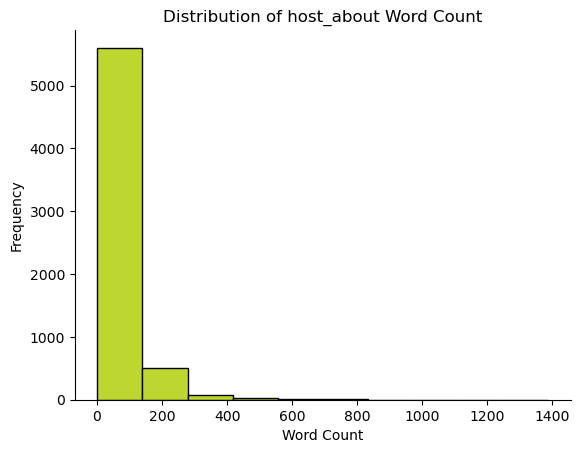

In [37]:
airbnb_df_train['word_count_host'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of host_about Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest description of the host has 1387 words
- The smallest description of the host has only 1 word
- On average, descriptions of the hosts  have around 74 words
- The *host_about* filed has generally smaller text [0,100] words, but also has extreme outliers with 10 times more words.

##### **3) Word Analysis** 
We now analyse each word individually:

In [38]:
all_words_host= ' '.join(airbnb_df_train['host_about']).split()

In [39]:
freq_host = pd.Series(all_words_host).value_counts() #see frequency of words

Cheking the most common words:

In [40]:
freq_host.sort_values(ascending=False)[0:20]

and        16358
to         13291
the        10797
a          10535
in          9860
of          6524
I           6419
you         6248
de          4325
We          4206
our         4004
e           3980
_x000D_     3971
for         3864
with        3819
is          3506
we          3481
are         2929
have        2825
my          2750
Name: count, dtype: int64

Vizualising using a barplot:

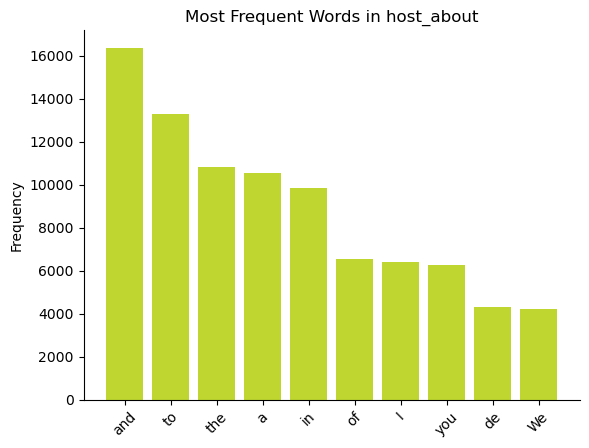

In [41]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in host_about')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

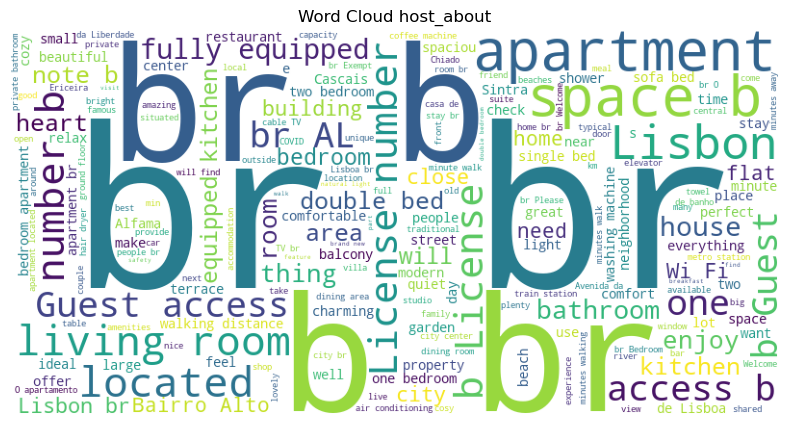

In [42]:
# Joining all the host_about into a single string
all_reviews_host = ' '.join(airbnb_df_train['host_about'])
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud host_about')
plt.show()

**Conclusions:**

There are clearly a lot of uniformative words that can be considered stop words, tags or non-alphanumeric, such as 'br', 'and', 'to'.\
These words should be correctly pre-processed as to not affect the outcome of our final analysis.

#### **2.2.4 comments:**

*from _reviews*

##### **1) Missing Values & Duplicates**

In [43]:
airbnb_df_train_reviews['comments'].isna().sum()

2

In [44]:
rows_with_nan_comments = airbnb_df_train_reviews[airbnb_df_train_reviews['comments'].isna()]
rows_with_nan_comments

,index,comments
97996,1654,NaN
334443,5789,NaN


In [45]:
airbnb_df_train_reviews['comments'].duplicated().sum()

6781

**Conclusions:**

We have **2 missing values** and have **many duplicated values**.

##### **2) Word Count** 
Repeat the process but this time for the variable *comments*

In [46]:
airbnb_df_train_reviews['word_count_rev']  = airbnb_df_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_reviews[['comments','word_count_rev']].head() #number of tokens

,comments,word_count_rev
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [47]:
airbnb_df_train_reviews.word_count_rev.describe().round(2)

count    361281.00
mean         47.97
std          46.79
min           1.00
25%          18.00
50%          36.00
75%          63.00
max        1019.00
Name: word_count_rev, dtype: float64

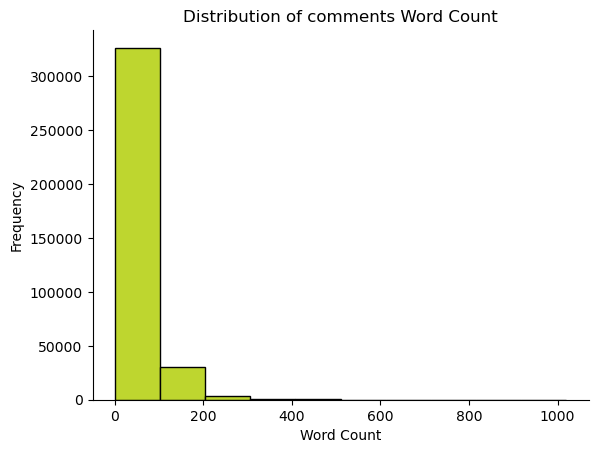

In [48]:
airbnb_df_train_reviews['word_count_rev'].hist(ec = 'black', color=['#BED62F'])
plt.grid(False)  
plt.title('Distribution of comments Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Conclusions**:
From these descriptive statistics and histogram, we can understand some interesting things about our data, such as:
- The largest comment has 1019 words
- The smallest comment has only 1 word
- On average, comments of the hosts  have around 48 words
- Just as with *host_about*, most *comments* have around [1,63] words but some outliers are 10 times bigger.

##### **3) Word Analysis** 
We now analyse each word individually:

In [49]:
# all_words_rev= ' '.join(airbnb_df_train_reviews['comments']).split()

TypeError: sequence item 97996: expected str instance, float found

The code line from above would not work as we are dealing with a variable with missing values encoded as *NaN*. This being said, we explore the problem further:

In [50]:
# if we has a lot more missing values, this would be even more useful
problematic_indices = []

for index, comment in airbnb_df_train_reviews['comments'].items():
    if isinstance(comment, float):
        problematic_indices.append(index)

problematic_rows = airbnb_df_train_reviews.loc[problematic_indices]
print(problematic_rows)

        index comments  word_count_rev
97996    1654      NaN               1
334443   5789      NaN               1


In [51]:
# The problem occurs because we have missing values, so let's not consider them
# (drop them 'temporarly' - create a separate variable, didn't drop them from original df)

comments_without_missing = airbnb_df_train_reviews['comments'].dropna()
all_words_rev = ' '.join(comments_without_missing).split()

In [52]:
freq_rev = pd.Series(all_words_rev).value_counts() #see frequency of words

Cheking the most common words:

In [53]:
freq_rev.sort_values(ascending=False)[0:15]

and          553157
the          515963
a            398631
to           328675
is           258191
in           249469
was          239807
of           174087
very         156654
The          143987
for          141658
de           139290
with         115782
apartment    114848
we            98283
Name: count, dtype: int64

Vizualising using a barplot:

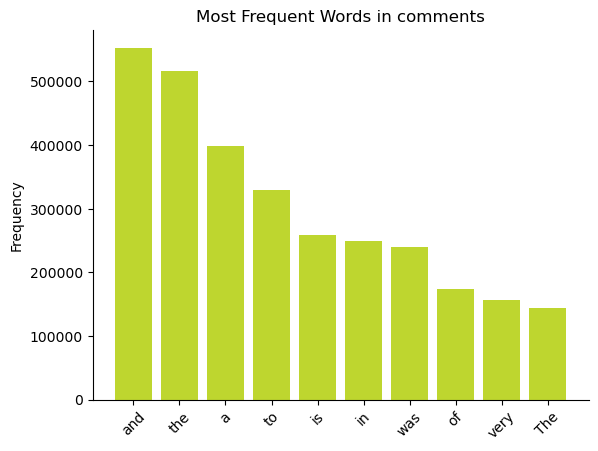

In [54]:
x_labels = freq_rev.index[0:10]
values = freq_rev[:10]
plt.bar(x_labels, values, color=['#BED62F'] )
plt.xticks(x_labels)
plt.ylabel('Frequency')
plt.title('Most Frequent Words in comments')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation = 45)
plt.show()

Visualizing using a word cloud:

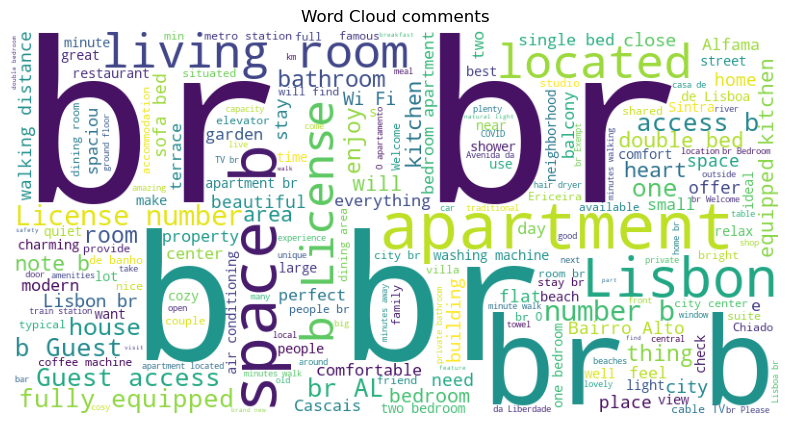

In [55]:
# Joining all the comments into a single string
all_reviews_rev = ' '.join(comments_without_missing)
    
# Create WordCloud object
wordcloud_descr = WordCloud(width=800, height=400, background_color="white").generate(all_reviews_descr)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descr)
plt.axis("off")
plt.title('Word Cloud comments')
plt.show()

#### **Dealing with Multi-Language Barrier:**

As was noted earlier, our text is written in many different languages. An important step of our analysis is to understand the proportions in which each language is present in our text, as to select the best approach going forward.

------

**Conclusions:**

There are clearly a lot of uniformative words that can be considered stop words, tags or non-alphanumeric, such as 'br', 'and' 'the'.\
These word should be correctly pre-processed as to not affect the outcome of our final analysis.

### **2.3 Conclusions Data Exploration:**
- Target variable *unlisted* is unbalanced (73/27);
- Text fields appear in many languages;
- Duplicated entries will be considered different properties;
- Missing values were found for the field *comments*;
- All text fields have many stop words, tags and non-alphanumeric words that should be removed for a better analysis.


**By the end of topic we should have:**
- Analyze the corpora; 
- Provide Conclusions;
- Provide Visual Information (bar chart, word cloud…) with context;

There are no extra points.


Reference: 
- https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
- https://spotintelligence.com/2023/09/15/exploratory-data-analysis-nlp/

------

## **3. Data Preprocessing**

- Split Training corpus intro train/validation sets (or also K-Fold Cross Validation or others);
- Implement at least 4 preprocessing techniques (stop words, regular expressions, lemmatization, stemming, …)
- Apply more data exploration after preprocessing.

Extra work: 0.25 points for each extra method (unseen in class) - max 2 methods



1. Normalization:
- Replace links with special token
- Normalize dates
- Regular expressions

2. LowerCasing

3. Tokenization
- Coumpounds
- Punctuation
4. Remove Stop-Words

5. Stemming and lemmatisation
6. POS filtering


###  **3.1 Some details before continuing preprocessing:**

####  **3.1.1 Dealing with Missing Values:**

Lets start by dealing with the missing values found:

In [56]:
airbnb_df_train_reviews['comments'].isna().sum()

2

In [57]:
# Filling the missing values with 'blankspace'
airbnb_df_train_reviews['comments'] = airbnb_df_train_reviews['comments'].fillna('')

In [58]:
airbnb_df_train_reviews['comments'].isna().sum()

0

In [59]:
airbnb_df_train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           361281 non-null  int64 
 1   comments        361281 non-null  object
 2   word_count_rev  361281 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [60]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 1 to 6248
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   description       6248 non-null   object
 1   host_about        6248 non-null   object
 2   unlisted          6248 non-null   int64 
 3   word_count_descr  6248 non-null   int64 
 4   word_count_host   6248 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 292.9+ KB


####  **3.1.2 HTML tags:**

One of the problems detected was the presence of HTML tags in the documents, so we will remove it, the **Beautiful Soup**.

* **Beautiful Soup**: Python library used for parsing HTML and XML documents, providing convenient methods for navigating, searching, and modifying the parse tree.
* documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [61]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    return clean_text

In [62]:
airbnb_df_train['description'] = airbnb_df_train['description'].apply(remove_html_tags)
airbnb_df_train['host_about'] = airbnb_df_train['host_about'].apply(remove_html_tags)
airbnb_df_train_reviews['comments'] = airbnb_df_train_reviews['comments'].apply(remove_html_tags)

C:\Users\susan\AppData\Local\Temp\ipykernel_12924\335289268.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


####  **3.1.3 Saving an original dataframe for each of the sets:**

In [63]:
# create a copy for preprocessing
# abb (AirBnB) / pp (PreProcessing)

abb_pp_train = airbnb_df_train.copy()

In [64]:
# create a copy of reviews for preprocessing
# abb (AirBnB) / pp (PreProcessing) / rvws (ReVieWs)

abb_pp_rvws_train = airbnb_df_train_reviews.copy()

####  **3.1.4 Language detection:**

Before continuing to the usual preprocessing steps, it's important to perform a language identification, to adapt further mehtods to the existing languages. <br>
**Options:**

- `langdetect` <br>

supports 55 languages <br>
to enforce consistent results: <br>
    `from langdetect import DetectorFactory` <br>
    `DetectorFactory.seed = 24` <br>

*Documentation*: <br>
https://pypi.org/project/langdetect <br>

In [65]:
# Try consistent results:
DetectorFactory.seed = 24

# Using langdetect library, defining a function to detect the language of the input text:
def id_language(text):
    try:
        return detect(text)
    except:
        return "Unknown"        # if it doesn't recognize the language


In [66]:
# Checking languages on train ('description') - using langdetect
# Introducing new column 'dscp_lg'

abb_pp_train['dscp_lg'] = abb_pp_train['description'].apply(id_language)

In [68]:
# Checking languages on train_review ('comments') - using langdetect
# Introducing new column 'comms_lg'

abb_pp_rvws_train['comms_lg'] = abb_pp_rvws_train['comments'].apply(id_language)


In [ ]:
abb_pp_train.head()

In [ ]:
abb_pp_rvws_train.head()

**Maybe try spaCy instead of FastText-Langdetect?** <br>
https://pypi.org/project/spacy-langdetect/ <br>
https://spacy.io/

- `fasttext-langdetect` <br>

up to 139/176 languages <br>
benchmarked agains langdetect with better scores <br>

*Documentation*: <br>
https://pypi.org/project/fasttext-langdetect/ <br>
https://fasttext.cc/docs/en/alnguage-identification.html

In [67]:
# Using FastText - langdetect library, defining a function to identify the language of the input text:
def id_ft_language(text):
    try:
        return ft_detect(text)          # Problems on imports
    except:
        return "Unknown"        # if it doesn't recognize the language

In [ ]:
# Checking languages on train ('description') - using FastText-langdetect
# Introducing new column 'dscp_ft_lg'

#abb_pp_train['dscp_ft_lg'] = abb_pp_train['description'].apply(id_ft_language)



# Checking languages on train_review ('comments') - using FastText-langdetect
# Introducing new column 'comms_ft_lg'

#abb_pp_rvws_train['comms_ft_lg'] = abb_pp_rvws_train['comments'].apply(id_ft_language)

### **3.2 Preprocessing:** <br>
(*according to slide 55 of 1st TP class - alhtough optinal*)

>> **Crise existencial de como passar de dataframe para algo que passe dentro da função sem dar merda?** <br>
Ele nos slides diz que a tokenization aparece em terceiro, mas secalhar tem que ser em primeiro. <br>

>> A célula de id de idiomas nas reviews ficou a correr indeterminadamente, depois do pc morrer várias vezes com o conteúdo anterior. Deixo sugestões de código, mas não sei se estão fully working.

#### 3.2.1 Normalization

Can the HTML code be considered inside ''regular expressions'' thing? <br>
Since we don't have dates, nor links, I don't get anything else that might be used. <br>
Okay, maybe include the monetary signs?

In [ ]:
# function to change monetary signs for #money_value
def monetary_signs(text):
    ms_text = re.sub('[$€£]\d+', '#Money_Value', text)
    return ms_text

#### 3.2.2 Lowercasing

In [ ]:
# lwc_df: lowercase dataframe - maybe not df, mas o que seja
# tkn: token em vez de word para não parecer tão repetido ao da aula

lwc_df = [tkn.lower() for tkn in lwc_df]

#### 3.2.3 Tokenization

In [ ]:
def tokenization(text):
    tk_text = word_tokenize(text)
    return tk_text

#### 3.2.4 Stop words, Stemming & Lemmatization

>> Needs more development to be introduced in the detected languages.

In [ ]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [237]:

def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for text in tqdm(text_list):
        
        # Lowercase text
        text = text.lower()
        
        # Remove unnecessary tags and all non-alphabetic characters
        text = re.sub("<br />", "", text)
        text = re.sub("[^a-zA-Z]"," ", text)
        # [^&] - Returns a match for any character EXCEPT &.
        # a-zA-Z - Returns a match for any character alphabetically between a and z, lower case or upper case.
        
        # Remove stopwords
        text = " ".join([word for word in text.split() if word not in stop])
        
        # Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [241]:
updates_description = clean(airbnb_df_train['description'], lemmatize = True, stemmer = False)

100%|██████████| 6248/6248 [00:09<00:00, 654.75it/s] 


In [242]:
updates_host = clean(airbnb_df_train['host_about'], lemmatize = True, stemmer = False)

100%|██████████| 6248/6248 [00:02<00:00, 2528.89it/s]


In [243]:
updates_comments = clean(airbnb_df_train_reviews['comments'], lemmatize = True, stemmer = False)

100%|██████████| 361281/361281 [01:51<00:00, 3246.66it/s]


To check the differcence after and before the cleaning, lets co

In [247]:
airbnb_df_train['description'][50]


'Show up and start living from day one in Lisbon with this cozy two-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Baixa home. (ID #LIS48) The space Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this two-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living.  Amenities Building amenities unique to this two-bedroom include an on-site:   - Elevator Please check the house rules prior to booking as other fees and limitations may apply. Other things to note This Blueground apartment has fl'

In [249]:
def update_df(dataframe, column_name, list_updated):
    list_updated.insert(0, None)  # adding an empty object to the first position of the list, so that the ids match with the dataframe
    dataframe.update(pd.DataFrame({column_name: list_updated}))

In [250]:
update_df(airbnb_df_train, 'description', updates_description)
update_df(airbnb_df_train, 'host_about', updates_host)
update_df(airbnb_df_train_reviews, 'comments', updates_comments)

In [251]:
airbnb_df_train['description'][50]

'show start living day one lisbon cozy two bedroom blueground apartment love coming home thoughtfully furnished beautifully designed fully equipped baixa home id li space gorgeous furniture fully equipped kitchen smart tv premium wireless speaker amenity find inside two bedroom apartment ideally located lisbon find lot love outside well ready relax happy discover every blueground bedroom come superior quality mattress luxury linen cozy towel handle everything simply show start living amenity building amenity unique two bedroom include site elevator please check house rule prior booking fee limitation may apply thing note blueground apartment fl'

----

### Feature Engineering:
Implement and experiment with 2 of feature engineering techniques (TF-IDF, GloVe embedding, …).

Extra work: 1 point for each extra method using Transformed-based embedding.- max 2 methods



-----

### Classification Models:
Implement and test 3 of the classification algorithms seen in class (KNN, LR, MLP, LSTM, …).

Extra work: 1 point for each extra model using Transformers or other advanced models - max 2 methods.



- Use KNN as baseline

----

### Evaluation:
Evaluate with, at least, Recall, Precision, Accuracy and F1-Score.
